In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

def plot_density_overlay_slice(ct_path, seg_path, slice_index, zoom_center=(100, 200), zoom_radius=100):
    # Load CT and segmentation
    ct_img = nib.load(ct_path)
    hu = np.asanyarray(ct_img.dataobj)  # raw HU values

    # Apply rescale (if needed)
    slope, intercept = ct_img.header.get_slope_inter()
    if slope is None or np.isnan(slope): slope = 1.0
    if intercept is None or np.isnan(intercept): intercept = 0.0
    hu = hu * slope + intercept

    # Convert to density and clip to valid range
    density = np.clip(1.0 + (hu / 1000.0), a_min=0.0, a_max=None)

    # Load segmentation
    seg = nib.load(seg_path).get_fdata().astype(bool)

    # Select axial slice
    hu_slice = hu[:, :, slice_index]
    density_slice = density[:, :, slice_index]
    tumor_mask_slice = seg[:, :, slice_index]

    # Create masked array for tumor density
    tumor_density_overlay = np.ma.masked_where(~tumor_mask_slice, density_slice)
    
    # Zoom logic
    if zoom_center is not None:
        cx, cy = zoom_center
        r = zoom_radius
        hu_slice = hu_slice[cx - r:cx + r, cy - r:cy + r]
        tumor_density_overlay = tumor_density_overlay[cx - r:cx + r, cy - r:cy + r]

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(hu_slice.T, cmap='gray', origin='lower', vmin=-1000, vmax=500)

    # Use a colormap where blue = low, red = high
    cmap_overlay = plt.cm.get_cmap('jet').copy()
    cmap_overlay.set_bad(color='none')  # Transparent where not tumor

    # Overlay tumor density
    plt.imshow(tumor_density_overlay.T, cmap=cmap_overlay, origin='lower', alpha=0.7)
    plt.colorbar(label='Tumor Density (g/cm³)')

    plt.title(f"CT Slice {slice_index} with Tumor Density Overlay")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"tumor_density_overlay_slice_{slice_index}.png", dpi=300)
    plt.show()


Voxel Spacing (x, y, z): (0.625, 0.625, 3.0)
[INFO] CT volume shape: (512, 512, 106)


C:\Users\sacha\AppData\Local\Temp\ipykernel_34620\367794683.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_overlay = plt.cm.get_cmap('jet').copy()


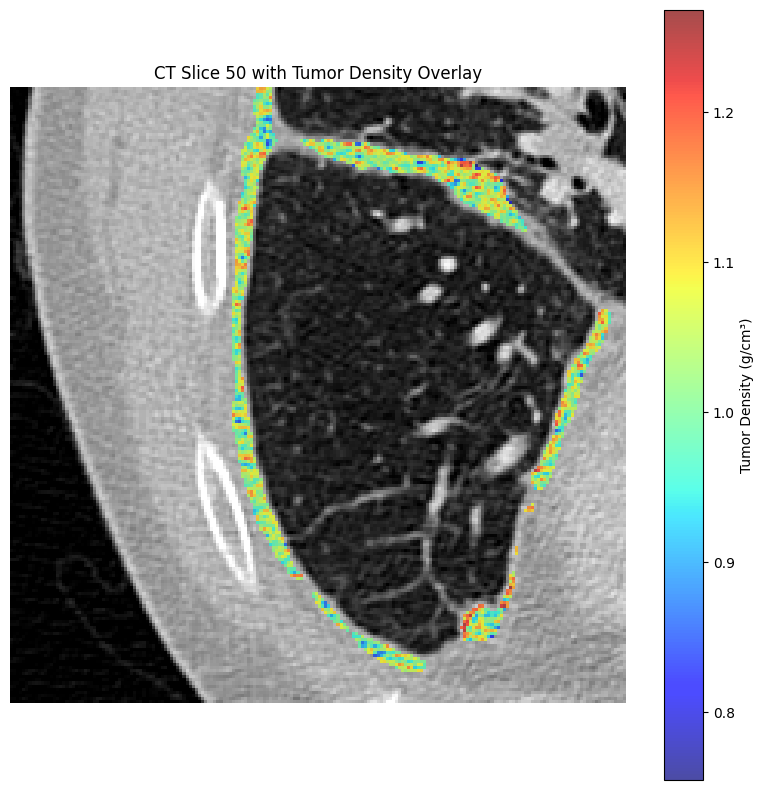

plot density overlay slice


In [ ]:
ct_img = nib.load(ct_scan_path)
print
seg_mask = nib.load(seg_mask_path).get_fdata().astype(bool)
segmentation = nib.load(seg_mask_path)
spacing = segmentation.header.get_zooms()  
print("Voxel Spacing (x, y, z):", spacing)

print(f"[INFO] CT volume shape: {ct_img.shape}")

plot_density_overlay_slice(ct_scan_path, seg_mask_path, 50)
print("plot density overlay slice")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.ndimage import uniform_filter

def plot_density_overlay_slice_with_neighbors(ct_path, seg_path, slice_index):
    # Load CT scan
    ct_img = nib.load(ct_path)
    hu = np.asanyarray(ct_img.dataobj).astype(np.float32)

    # Apply scaling
    slope, intercept = ct_img.header.get_slope_inter()
    if slope is None or np.isnan(slope): slope = 1.0
    if intercept is None or np.isnan(intercept): intercept = 0.0
    hu = hu * slope + intercept

    # Convert HU to physical density
    density = np.clip(1.0 + (hu / 1000.0), a_min=0.0, a_max=None)

    # Load segmentation mask
    seg = nib.load(seg_path).get_fdata().astype(bool)

    # Extract 2D slice
    hu_slice = hu[:, :, slice_index]
    density_slice = density[:, :, slice_index]
    tumor_mask_slice = seg[:, :, slice_index]

    # === Apply 5×5 neighborhood average ===
    kernel_size = 5  # same as N=2 in earlier logic
    avg_density_slice = uniform_filter(density_slice, size=kernel_size, mode='nearest')

    # Mask for tumor region
    tumor_density_overlay = np.ma.masked_where(~tumor_mask_slice, avg_density_slice)

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(hu_slice.T, cmap='gray', origin='lower', vmin=-1000, vmax=500)

    # Use a colormap where blue = low, red = high
    cmap_overlay = plt.cm.get_cmap('jet').copy()
    cmap_overlay.set_bad(color='none')  # Transparent where not tumor

    # Overlay tumor density
    plt.imshow(tumor_density_overlay.T, cmap=cmap_overlay, origin='lower', alpha=0.7)
    plt.colorbar(label='Tumor Density (g/cm³)')

    plt.title(f"CT Slice {slice_index} with Tumor Density Overlay")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"tumor_density_overlay_slice_{slice_index}.png", dpi=300)
    plt.show()


Voxel Spacing (x, y, z): (0.625, 0.625, 3.0)
[INFO] CT volume shape: (512, 512, 106)


C:\Users\sacha\AppData\Local\Temp\ipykernel_15224\3837139450.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_overlay = plt.cm.get_cmap('jet').copy()


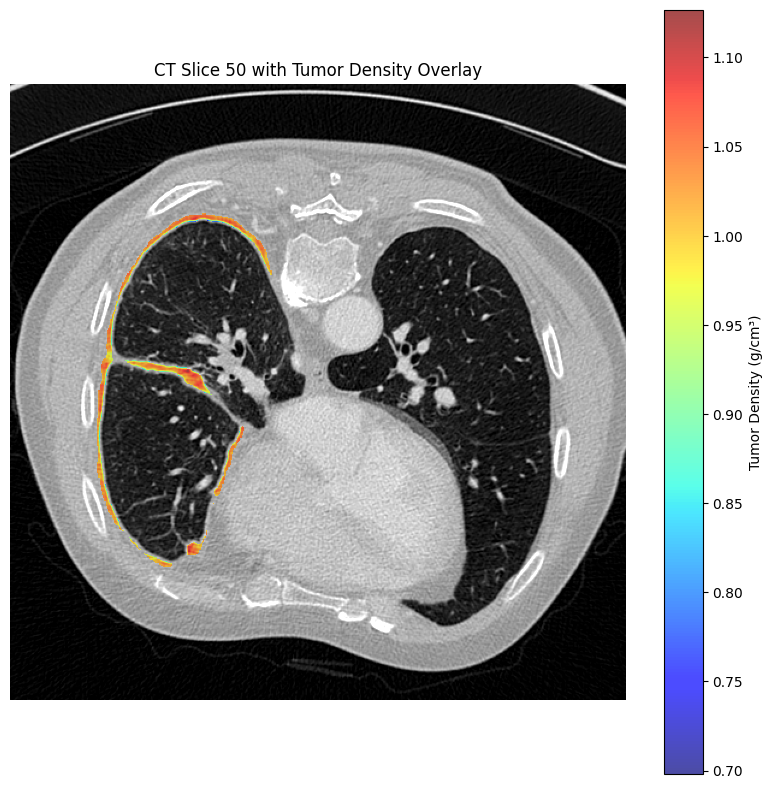

In [ ]:
ct_img = nib.load(ct_scan_path)
print
seg_mask = nib.load(seg_mask_path).get_fdata().astype(bool)
segmentation = nib.load(seg_mask_path)
spacing = segmentation.header.get_zooms()  
print("Voxel Spacing (x, y, z):", spacing)

print(f"[INFO] CT volume shape: {ct_img.shape}")

plot_density_overlay_slice_with_neighbors(ct_scan_path, seg_mask_path, 50)

In [18]:
def plot_density_overlay_slice_with_neighbors_zoom(ct_path, seg_path, slice_index, zoom_center=None, zoom_radius=50):
    import matplotlib.pyplot as plt
    import numpy as np
    import nibabel as nib
    from matplotlib.colors import LinearSegmentedColormap, Normalize
    from scipy.ndimage import uniform_filter

    # Load CT scan
    ct_img = nib.load(ct_path)
    hu = np.asanyarray(ct_img.dataobj).astype(np.float32)

    # Apply scaling
    slope, intercept = ct_img.header.get_slope_inter()
    if slope is None or np.isnan(slope): slope = 1.0
    if intercept is None or np.isnan(intercept): intercept = 0.0
    hu = hu * slope + intercept

    # Convert to density
    density = np.clip(1.0 + (hu / 1000.0), a_min=0.0, a_max=None)

    # Load segmentation
    seg = nib.load(seg_path).get_fdata().astype(bool)

    # Extract slices
    hu_slice = hu[:, :, slice_index]
    density_slice = density[:, :, slice_index]
    tumor_mask_slice = seg[:, :, slice_index]

    # Apply 5×5 neighborhood averaging
    avg_density_slice = uniform_filter(density_slice, size=5, mode='nearest')
    tumor_density_overlay = np.ma.masked_where(~tumor_mask_slice, avg_density_slice)

    # Zoom logic
    if zoom_center is not None:
        cx, cy = zoom_center
        r = zoom_radius
        hu_slice = hu_slice[cx - r:cx + r, cy - r:cy + r]
        tumor_density_overlay = tumor_density_overlay[cx - r:cx + r, cy - r:cy + r]

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(hu_slice.T, cmap='gray', origin='lower', vmin=-1000, vmax=500)

    # Use a colormap where blue = low, red = high
    cmap_overlay = plt.cm.get_cmap('jet').copy()
    cmap_overlay.set_bad(color='none')  # Transparent where not tumor

    # Overlay tumor density
    plt.imshow(tumor_density_overlay.T, cmap=cmap_overlay, origin='lower', alpha=0.7)
    plt.colorbar(label='Tumor Density (g/cm³)')

    plt.title(f"CT Slice {slice_index} with Tumor Density Overlay")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"tumor_density_overlay_slice_{slice_index}.png", dpi=300)
    plt.show()

C:\Users\sacha\AppData\Local\Temp\ipykernel_15224\4023333171.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_overlay = plt.cm.get_cmap('jet').copy()


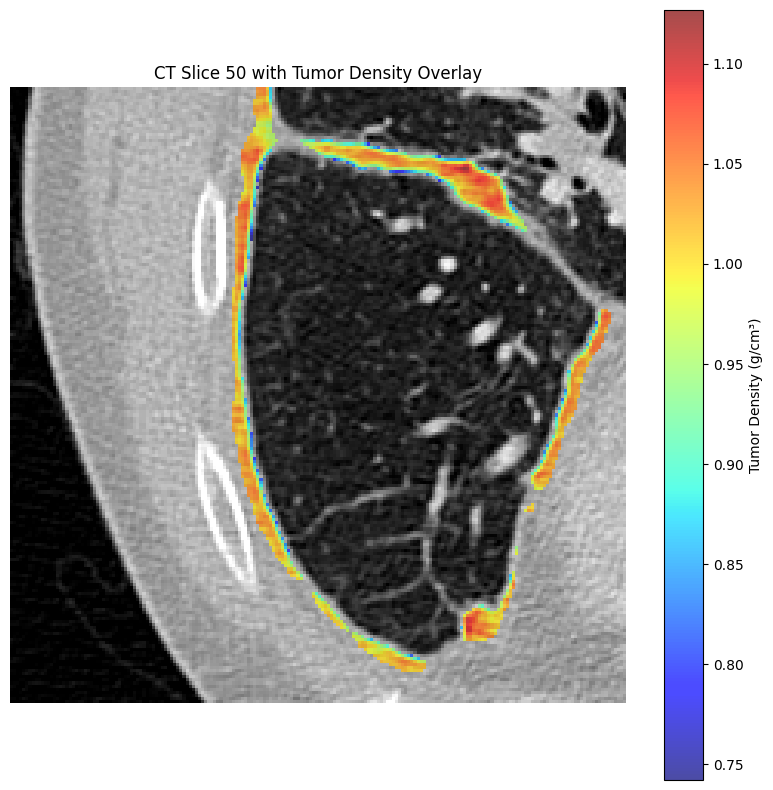

In [25]:
plot_density_overlay_slice_with_neighbors_zoom(
    ct_scan_path, seg_mask_path, 50, zoom_center=(100, 200), zoom_radius=100
)

HU NaN count: 0
HU range: -1024.0 to 2687.0


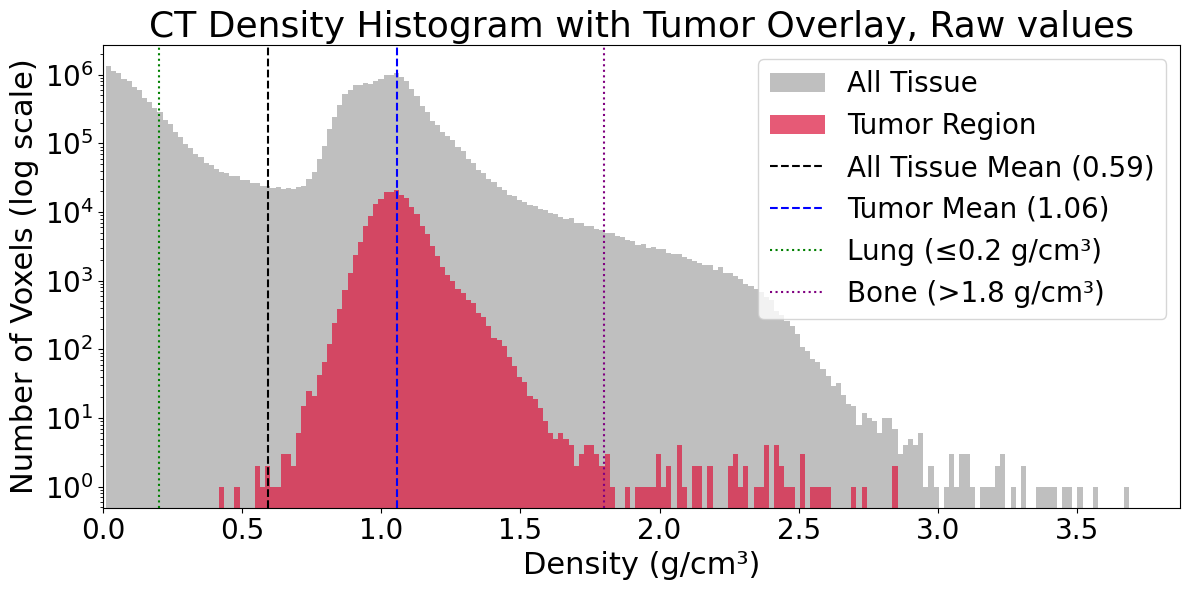

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

def plot_density_histogram_overlay(ct_path, seg_path, use_log=False):
    # Load CT and segmentation
    ct_img = nib.load(ct_path)
    ct_data = ct_img.get_fdata()

    # Convert to HU (already scaled with get_fdata) and then density
    hu = ct_data
    print("HU NaN count:", np.isnan(hu).sum())
    print("HU range:", np.nanmin(hu), "to", np.nanmax(hu))

    # Convert to density (clip negative densities)
    density = np.clip(1.0 + (hu / 1000.0), a_min=0.0, a_max=None)

    # Load and apply tumor segmentation
    seg_mask = nib.load(seg_path).get_fdata().astype(bool)
    tumor_densities = density[seg_mask]
    tumor_hu = hu[seg_mask]

    all_densities = density.flatten()
    all_hu = hu.flatten()

    # Compute means
    tumor_mean = np.mean(tumor_densities)
    full_mean = np.mean(all_densities)

    # Create plot
    plt.figure(figsize=(12, 6))
    bins = np.linspace(0.01, np.max(density), 200)

    plt.hist(all_densities, bins=bins, alpha=0.5, label='All Tissue', color='gray')
    plt.hist(tumor_densities, bins=bins, alpha=0.7, label='Tumor Region', color='crimson')

    # Mean lines
    plt.axvline(full_mean, color='black', linestyle='--', label=f'All Tissue Mean ({full_mean:.2f})')
    plt.axvline(tumor_mean, color='blue', linestyle='--', label=f'Tumor Mean ({tumor_mean:.2f})')

    # Annotate lung and bone
    plt.axvline(0.2, color='green', linestyle=':', label='Lung (≤0.2 g/cm³)')
    plt.axvline(1.8, color='purple', linestyle=':', label='Bone (>1.8 g/cm³)')

    # Set axis limits
    plt.xlim(left=0.0)

    # Labels and legend (increased font size)
    plt.xlabel("Density (g/cm³)", fontsize=22)
    plt.ylabel("Number of Voxels", fontsize=22)
    plt.title("CT Density Histogram with Tumor Overlay, Raw values", fontsize=26)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='upper right', fontsize=20)

    if use_log:
        plt.yscale("log")
        plt.ylabel("Number of Voxels (log scale)", fontsize=22)


    plt.tight_layout()
    plt.savefig("tumor_density_histogram_annotated.png", dpi=300)
    plt.show()

    # Optionally save HU arrays
    np.save("hu_all_voxels.npy", all_hu)
    np.save("hu_tumor_voxels.npy", tumor_hu)

# Call function
plot_density_histogram_overlay(
    "CT_scan.nii.gz",
    "Segmentation.nii.gz",
    use_log=True
)


HU NaN count: 0
HU range: -1024.0 to 2687.0


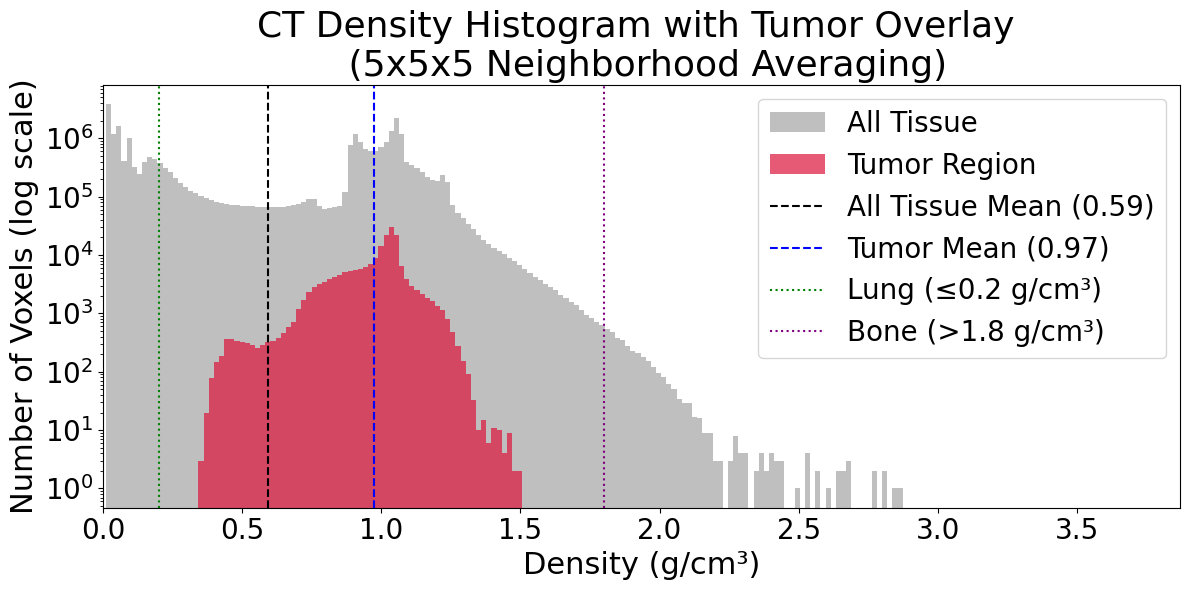

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import uniform_filter

def plot_density_histogram_overlay_avg(ct_path, seg_path, use_log=False):
    # Load CT and segmentation
    ct_img = nib.load(ct_path)
    ct_data = ct_img.get_fdata()
    hdr = ct_img.header

    # Convert to HU and then to density
    hu = ct_data
    print("HU NaN count:", np.isnan(hu).sum())
    print("HU range:", np.nanmin(hu), "to", np.nanmax(hu))
    density = np.clip(1.0 + (hu / 1000.0), a_min=0.0, a_max=None)

    # Apply 5x5x5 neighborhood averaging to the density
    density_avg = uniform_filter(density, size=5, mode='nearest')

    # Load and apply tumor segmentation
    seg_mask = nib.load(seg_path).get_fdata().astype(bool)
    tumor_densities = density_avg[seg_mask]
    tumor_hu = hu[seg_mask]  # raw HU values for tumor

    all_densities = density_avg.flatten()
    all_hu = hu.flatten()

    # Compute means
    tumor_mean = np.mean(tumor_densities)
    full_mean = np.mean(all_densities)

    # Create plot
    plt.figure(figsize=(12, 6))
    bins = np.linspace(0.01, np.max(density), 200)

    plt.hist(all_densities, bins=bins, alpha=0.5, label='All Tissue', color='gray')
    plt.hist(tumor_densities, bins=bins, alpha=0.7, label='Tumor Region', color='crimson')

    # Mean lines
    plt.axvline(full_mean, color='black', linestyle='--', label=f'All Tissue Mean ({full_mean:.2f})')
    plt.axvline(tumor_mean, color='blue', linestyle='--', label=f'Tumor Mean ({tumor_mean:.2f})')

    # Annotate lung and bone
    plt.axvline(0.2, color='green', linestyle=':', label='Lung (≤0.2 g/cm³)')
    plt.axvline(1.8, color='purple', linestyle=':', label='Bone (>1.8 g/cm³)')

    # Set axis limits
    plt.xlim(left=0.0)

    # Labels and legend (increased font size)
    plt.xlabel("Density (g/cm³)", fontsize=22)
    plt.ylabel("Number of Voxels", fontsize=22)
    plt.title("CT Density Histogram with Tumor Overlay \n (5x5x5 Neighborhood Averaging)", fontsize=26)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='upper right', fontsize=20)

    if use_log:
        plt.yscale("log")
        plt.ylabel("Number of Voxels (log scale)", fontsize=22)

    plt.tight_layout()
    plt.savefig("tumor_density_histogram_annotated.png", dpi=300)
    plt.show()

    # Optionally save HU arrays
    np.save("hu_all_voxels.npy", all_hu)
    np.save("hu_tumor_voxels.npy", tumor_hu)

# Call the function
plot_density_histogram_overlay_avg(
    "CT_scan.nii.gz",
    "Segmentation.nii.gz",
    use_log=True
)
